In [1]:
import os
os.chdir("/home/user/src")
os.listdir()

['model.py',
 'notebooks',
 'aux',
 'train.py',
 'configs',
 '__pycache__',
 'utils.py',
 'main.py',
 'dataset.py']

In [2]:
import torch
import hydra
import omegaconf
import rasterio as rio
import glob
import math

import torch
import torch.nn as nn
import numpy as np


import matplotlib.pyplot as plt
from utils import preprocess_s2, s2toRGB

In [3]:
checkpoint = "/home/user/results/cnn/2024-09-19_14:38:45/model_checkpoints/checkpoint_101_39000.pt"
configdir = "./configs/vgg.yaml"
data_topdir = "/home/user/datainference"

In [4]:
cfg = omegaconf.OmegaConf.load(configdir)
model = hydra.utils.instantiate(cfg.model)

In [5]:
state_dict = torch.load(checkpoint,map_location=torch.device('cpu'))
model.load_state_dict(state_dict["model_state_dict"])
model = model.cpu()
model.eval()


pass

In [6]:
classnames = ["AnnualCrop","HerbaceousVegetation","AnnualCrop",
              "PermanentCrop","River","Forest","Highway",
              "Pasture","Residential","SeaLake"]


samples = {}
for cn in classnames:
    samples[cn] = glob.glob(os.path.join(data_topdir,"**",f"*{cn}*.tif"),recursive=True)

data shape (13, 64, 64)


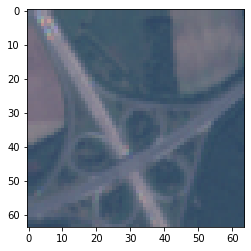

In [36]:
N = 6


with rio.open(samples["Highway"][N], "r") as src:
    data = preprocess_s2( src.read() )

print("data shape", data.shape)

plt.imshow(s2toRGB(data))
plt.savefig("residential.png",dpi=300)
plt.show()

In [37]:
x = torch.tensor(data,dtype=torch.float32).unsqueeze(0)
x.shape

torch.Size([1, 13, 64, 64])

In [38]:
cls = model(x)

In [39]:
cls

tensor([[ -56.2708,  -80.4383,  -79.5738,  -72.0476,  -65.4922, -128.9350,
           28.5335,  -70.6643,  -77.3206, -261.3134]],
       grad_fn=<AddmmBackward0>)

In [40]:
def model_naming(model):
    for i, layer in enumerate(model.model.features):
        if isinstance(layer, nn.Conv2d):  # Ensure we only store conv layers
            print(i)
    

model_naming(model)

0
3
6
8
11
13
16
18


In [41]:
layerlist = [0, 3, 8, 16]
layerslist = [x + 1 for x in layerlist]


def get_feature_maps(model, x, layers=layerlist):
    feature_maps = []
    
    for i, layer in enumerate(model.model.features):
        x = layer(x)  # Pass through the layer
        if isinstance(layer, nn.Conv2d) and i in layers:  # Ensure we only store conv layers
            feature_maps.append((i, x.clone().detach()))
    
    return feature_maps


def plot_feature_maps(feature_maps, max_maps=6):
    total_layers = len(feature_maps)
    fig, axes = plt.subplots(total_layers, max_maps, figsize=(15, 3 * total_layers))
    
    for row, (layer_idx, fmap) in enumerate(feature_maps):
        fmap = fmap[0]  # Remove batch dimension
        num_maps = min(fmap.shape[0], max_maps)
        for col in range(num_maps):
            axes[row, col].imshow(fmap[col].cpu().numpy(), cmap='plasma')
            axes[row, col].axis('off')
        for col in range(num_maps, max_maps):  # Hide unused subplots
            axes[row, col].axis('off')
        axes[row, 0].set_title(f'Layer {layer_idx}')
    
    plt.tight_layout()
    plt.savefig("feature_maps_residential.png",dpi=300)
    plt.show()

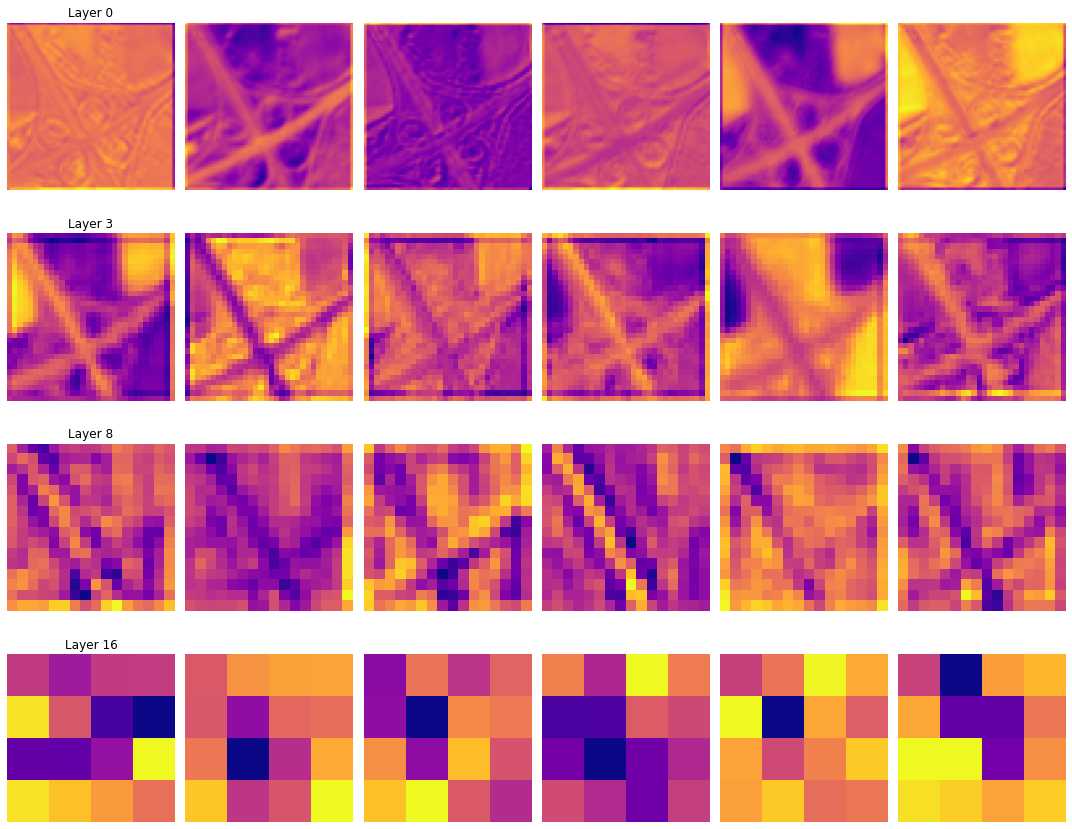

In [42]:

# Get feature maps
feature_maps = get_feature_maps(model, x)

# Plot feature maps
plot_feature_maps(feature_maps)

In [ ]:
model.model.features

Sequential(
  (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride